In [1]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import random
import operator
import pandas as pd
import scipy.io as sci
%matplotlib inline
def chunk(xs, n):
    ys = list(xs)
    random.shuffle(ys)
    size = len(ys) // n
    leftovers= ys[size*n:]
    for c in xrange(n):
        if leftovers:
           extra= [ leftovers.pop() ] 
        else:
           extra= []
        yield ys[c*size:(c+1)*size] + extra

In [2]:
def common_neighbours(sub):
    i = sub
    mat = np.array((nx.to_numpy_matrix(i) != 0) * 1).dot(np.array((nx.to_numpy_matrix(i) != 0) * 1))
    edgesWithScore = {}
    edges = nx.non_edges(i)
    for e in edges:
        edgesWithScore[e] = mat[e[0]][e[1]]
    return edgesWithScore 

def salton_index(sub):
    i = sub
    mat = np.array((nx.to_numpy_matrix(i) != 0) * 1).dot(np.array((nx.to_numpy_matrix(i) != 0) * 1))
    edgesWithScore = {}
    edges = nx.non_edges(i)
    for e in edges:
        j = nx.degree(i, e[0])
        k = nx.degree(i, e[1])
        if j != 0 and k != 0:
            edgesWithScore[e] = float(mat[e[0]][e[1]])/float(np.sqrt(j * k))
        else:
            edgesWithScore[e] = 0
    return edgesWithScore

def jaccard_index(sub):
    i = sub
    mat = np.array((nx.to_numpy_matrix(i) != 0) * 1).dot(np.array((nx.to_numpy_matrix(i) != 0) * 1))
    edgesWithScore = {}
    edges = nx.non_edges(i)
    for e in edges:
        if nx.degree(i, e[0]) != 0 or nx.degree(i, e[1]) != 0:
            edgesWithScore[e] = float(mat[e[0]][e[1]])/float(len(set(i[e[0]])|set(i[e[1]])))
        else:
            edgesWithScore[e] = 0
    return edgesWithScore

def sorensen_index(sub):
    i = sub
    mat = np.array((nx.to_numpy_matrix(i) != 0) * 1).dot(np.array((nx.to_numpy_matrix(i) != 0) * 1))
    edgesWithScore = {}
    edges = nx.non_edges(i)
    for e in edges:
        j = nx.degree(i, e[0])
        k = nx.degree(i, e[1])
        if j != 0 or k != 0:
            edgesWithScore[e] = 2*float(mat[e[0]][e[1]])/float(j + k)
        else:
            edgesWithScore[e] = 0
    return edgesWithScore

def hub_promoted_index(sub):
    i = sub
    mat = np.array((nx.to_numpy_matrix(i) != 0) * 1).dot(np.array((nx.to_numpy_matrix(i) != 0) * 1))
    edgesWithScore = {}
    edges = nx.non_edges(i)
    for e in edges:
        j = nx.degree(i, e[0])
        k = nx.degree(i, e[1])
        if j != 0 and k != 0:
            edgesWithScore[e] = float(mat[e[0]][e[1]])/float(min(j, k))
        else:
            edgesWithScore[e] = 0
    return edgesWithScore

def hub_depressed_index(sub):
    i = sub
    mat = np.array((nx.to_numpy_matrix(i) != 0) * 1).dot(np.array((nx.to_numpy_matrix(i) != 0) * 1))
    edgesWithScore = {}
    edges = nx.non_edges(i)
    for e in edges:
        j = nx.degree(i, e[0])
        k = nx.degree(i, e[1])
        if j != 0 or k != 0:
            edgesWithScore[e] = float(mat[e[0]][e[1]])/float(max(j, k))
        else:
            edgesWithScore[e] = 0
    return edgesWithScore

def LHN1_index(sub):
    i = sub
    mat = np.array((nx.to_numpy_matrix(i) != 0) * 1).dot(np.array((nx.to_numpy_matrix(i) != 0) * 1))
    edgesWithScore = {}
    edges = nx.non_edges(i)
    for e in edges:
        j = nx.degree(i, e[0])
        k = nx.degree(i, e[1])
        if j != 0 and k != 0:
            edgesWithScore[e] = float(mat[e[0]][e[1]])/float(j * k)
        else:
            edgesWithScore[e] = 0
    return edgesWithScore

def preferential_attachment_index(sub):
    i = sub
    edgesWithScore = {}
    edges = nx.non_edges(i)
    for e in edges:
        edgesWithScore[e] = nx.degree(i, e[0]) * nx.degree(i, e[1])
    return edgesWithScore

def adamic_adar_index(sub):
    i = sub
    edgesWithScore = {}
    edges = nx.non_edges(i)
    for e in edges:
        edgesWithScore[e] = np.sum(1/np.log(nx.degree(i, sorted(nx.common_neighbors(i, e[0], e[1]))).values()))
    return edgesWithScore

def resource_allocation_index(sub):
    i = sub
    edgesWithScore = {}
    edges = nx.non_edges(i)
    for e in edges:
        edgesWithScore[e] = np.sum(1/np.array(
                nx.degree(i, sorted(nx.common_neighbors(i, e[0], e[1]))).values()).astype(float))
    return edgesWithScore

def katz_index(sub):
    i = sub
    mat = np.array((nx.to_numpy_matrix(i) != 0) * 1.)
    ide = np.identity(len(mat))
    beta = (1/float(max(np.linalg.eigh(mat)[0])))/2
    sim = np.linalg.inv(ide - beta*mat) - ide
    edgesWithScore = {}
    edges = nx.non_edges(i)
    for e in edges:
        edgesWithScore[e] = sim[e[0]][e[1]]
    return edgesWithScore

def lhn2_index(sub, phi = 0.1):
    i = sub
    mat = np.array((nx.to_numpy_matrix(i) != 0) * 1.)
    ide = np.identity(len(mat))
    dma = np.diagflat(mat.sum(axis = 1))
    edgesWithScore = {}
    edges = nx.non_edges(i)
    for e in edges:
        edgesWithScore[e] = 0
    if np.linalg.det(dma) != 0:
        lambd = float(max(np.linalg.eigh(mat)[0]))
        sim = (2 * i.number_of_edges() * lambd * np.linalg.inv(dma)).dot(np.linalg.inv(
        ide - (phi/lambd) * mat)).dot(np.linalg.inv(dma))
        edges = nx.non_edges(i)
        for e in edges:
            edgesWithScore[e] = sim[e[0]][e[1]]
    return edgesWithScore

def act_index(sub):
    i = sub
    mat = np.array((nx.to_numpy_matrix(i) != 0) * 1.)
    dma = np.diagflat(mat.sum(axis = 1))
    sim = np.linalg.pinv(dma - mat)
    edgesWithScore = {}
    edges = nx.non_edges(i)
    for e in edges:
        if sim[e[0]][e[0]] + sim[e[1]][e[1]] - 2*sim[e[0]][e[1]] != 0:
            edgesWithScore[e] = 1/float(sim[e[0]][e[0]] + sim[e[1]][e[1]] - 2*sim[e[0]][e[1]])
        else:
            edgesWithScore[e] = 0
    return edgesWithScore

def cbl_index(sub):
    i = sub
    mat = np.array((nx.to_numpy_matrix(i) != 0) * 1.)
    dma = np.diagflat(mat.sum(axis = 1))
    sim = np.linalg.pinv(dma - mat)
    edgesWithScore = {}
    edges = nx.non_edges(i)
    for e in edges:
        if sim[e[0]][e[0]] * sim[e[1]][e[1]] != 0:
            edgesWithScore[e] = float(sim[e[0]][e[1]])/np.sqrt(sim[e[0]][e[0]] * sim[e[1]][e[1]])
        else:
            edgesWithScore[e] = 0
    return edgesWithScore

def rwr_index(sub, c = 0.5):
    i = sub
    mat = np.array((nx.to_numpy_matrix(i) != 0) * 1.)
    dma = np.diagflat(mat.sum(axis = 1))
    sim = np.linalg.pinv(dma - mat)
    ide = np.identity(len(mat))
    pmt = np.identity(len(mat))
    es = []
    for a in i.nodes():
        e = np.zeros(len(mat))
        e[a] = 1
        es.append(e)
        for b in i.nodes():
            try:
                nx.shortest_path_length(i, source = a, target = b)
            except:
                pmt[a][b] = 0
            else:
                if nx.degree(i, a) != 0:
                    pmt[a][b] = 1/float(nx.degree(i, a))
                else:
                    pmt[a][b] = 0
    es = np.array(es)
    qs = []
    for a in i.nodes():
        if np.linalg.det(ide - c*np.transpose(pmt)) != 0:
            q = ((1 - c)*np.linalg.inv(ide - c*np.transpose(pmt))).dot(es[a])
        else:
            q = es[a]
        qs.append(q)
    qs = np.array(qs)
    edgesWithScore = {}
    edges = nx.non_edges(i)
    for e in edges:
        edgesWithScore[e] = qs[e[0]][e[1]] + qs[e[1]][e[0]]
    return edgesWithScore

def matrix_forest_index(sub, alpha = 1):
    i = sub
    mat = np.array((nx.to_numpy_matrix(i) != 0) * 1.)
    dma = np.diagflat(mat.sum(axis = 1))
    ide = np.identity(len(mat))
    sim = np.linalg.inv(ide + alpha*(dma - mat))
    edgesWithScore = {}
    edges = nx.non_edges(i)
    for e in edges:
        edgesWithScore[e] = sim[e[0]][e[1]]
    return edgesWithScore

def predict_nodes(G, nfolds = 10):
    df = pd.DataFrame()
    random.seed(0)
    folds = [i for i in chunk(G.edges(), nfolds)]
    subs = []
    for i in xrange(nfolds):
        graph = G.copy()
        for c in folds[i]:
            graph.remove_edge(*c)
        subs.append(graph.copy())
    es = nx.non_edges(subs[0])
    edges = []
    y = {}
    for e in es:
        edges.append(e)
        check = 0
        if e in folds[0]:
            check = 1
        y[e] = check
    df['Edges'] = edges
    df['y'] = df['Edges'].map(y.get)
    df['CN'] = df['Edges'].map(common_neighbours(subs[0]).get)
    df['SaI'] = df['Edges'].map(salton_index(subs[0]).get)
    df['JI'] = df['Edges'].map(jaccard_index(subs[0]).get)
    df['SoI'] = df['Edges'].map(sorensen_index(subs[0]).get)
    df['HPI'] = df['Edges'].map(hub_promoted_index(subs[0]).get)
    df['HDI'] = df['Edges'].map(hub_depressed_index(subs[0]).get)
    df['LHN1'] = df['Edges'].map(LHN1_index(subs[0]).get)
    df['PAI'] = df['Edges'].map(preferential_attachment_index(subs[0]).get)
    df['AAI'] = df['Edges'].map(adamic_adar_index(subs[0]).get)
    df['RAI'] = df['Edges'].map(resource_allocation_index(subs[0]).get)
    df['KzI'] = df['Edges'].map(katz_index(subs[0]).get)
    df['LHN2'] = df['Edges'].map(lhn2_index(subs[0]).get)
    df['ACT'] = df['Edges'].map(act_index(subs[0]).get)
    df['CBL'] = df['Edges'].map(cbl_index(subs[0]).get)
    df['RWR'] = df['Edges'].map(rwr_index(subs[0]).get)
    df['MFI'] = df['Edges'].map(matrix_forest_index(subs[0]).get)
    return df

In [3]:
from sklearn.metrics import classification_report
from sklearn import preprocessing
from sklearn import linear_model
from sklearn import ensemble
from sklearn import svm
from sklearn import neighbors
from sklearn import tree
from sklearn import lda
from sklearn import qda
from sklearn import preprocessing
from sklearn import metrics

In [4]:
from sklearn import cross_validation
def run_10_fold_on_G(G, nfolds = 10):
    random.seed(0)
    folds = [i for i in chunk(G.edges(), nfolds)]
    frames = []
    for i in xrange(nfolds):
        graph = G.copy()
        for c in folds[i]:
            graph.remove_edge(*c)
        sub = graph.copy()
        df = pd.DataFrame()
        es = nx.non_edges(sub)
        edges = []
        y = {}
        for e in es:
            edges.append(e)
            if e in folds[i]:
                y[e] = 1
            else:
                y[e] = 0
        df['Edges'] = edges
        df['y'] = df['Edges'].map(y.get)
        df['CN'] = df['Edges'].map(common_neighbours(sub).get)
        df['SaI'] = df['Edges'].map(salton_index(sub).get)
        df['JI'] = df['Edges'].map(jaccard_index(sub).get)
        df['SoI'] = df['Edges'].map(sorensen_index(sub).get)
        df['HPI'] = df['Edges'].map(hub_promoted_index(sub).get)
        df['HDI'] = df['Edges'].map(hub_depressed_index(sub).get)
        df['LHN1'] = df['Edges'].map(LHN1_index(sub).get)
        df['PAI'] = df['Edges'].map(preferential_attachment_index(sub).get)
        df['AAI'] = df['Edges'].map(adamic_adar_index(sub).get)
        df['RAI'] = df['Edges'].map(resource_allocation_index(sub).get)
        df['KzI'] = df['Edges'].map(katz_index(sub).get)
        df['LHN2'] = df['Edges'].map(lhn2_index(sub).get)
        df['ACT'] = df['Edges'].map(act_index(sub).get)
        df['CBL'] = df['Edges'].map(cbl_index(sub).get)
        df['RWR'] = df['Edges'].map(rwr_index(sub).get)
        df['MFI'] = df['Edges'].map(matrix_forest_index(sub).get)
        df = df.fillna(0)
        frames.append(df)
        #print 'Done in fold', i+1
    return frames, folds

def run_indices_on_compl(sub, fold):
    df = pd.DataFrame()
    es = nx.non_edges(sub)
    edges = []
    y = {}
    for e in es:
        edges.append(e)
        if e in fold:
            y[e] = 1
        else:
            y[e] = 0
    df['Edges'] = edges
    df['y'] = df['Edges'].map(y.get)
    df['CN'] = df['Edges'].map(common_neighbours(sub).get)
    df['SaI'] = df['Edges'].map(salton_index(sub).get)
    df['JI'] = df['Edges'].map(jaccard_index(sub).get)
    df['SoI'] = df['Edges'].map(sorensen_index(sub).get)
    df['HPI'] = df['Edges'].map(hub_promoted_index(sub).get)
    df['HDI'] = df['Edges'].map(hub_depressed_index(sub).get)
    df['LHN1'] = df['Edges'].map(LHN1_index(sub).get)
    df['PAI'] = df['Edges'].map(preferential_attachment_index(sub).get)
    df['AAI'] = df['Edges'].map(adamic_adar_index(sub).get)
    df['RAI'] = df['Edges'].map(resource_allocation_index(sub).get)
    df['KzI'] = df['Edges'].map(katz_index(sub).get)
    df['LHN2'] = df['Edges'].map(lhn2_index(sub).get)
    df['ACT'] = df['Edges'].map(act_index(sub).get)
    df['CBL'] = df['Edges'].map(cbl_index(sub).get)
    df['RWR'] = df['Edges'].map(rwr_index(sub).get)
    df['MFI'] = df['Edges'].map(matrix_forest_index(sub).get)
    df = df.fillna(0)
    return df

def get_folds_test(G, alg = 'rf', nfolds = 10):
    f1s = []
    precisions = []
    recalls = []
    rocaucs = []
    accuracies = []
    avg_prcs = []
    random.seed(0)
    frames, folds = run_10_fold_on_G(G)
    edges = []
    for e in nx.non_edges(G):
        edges.append(e)
    zeros = [i for i in chunk(edges, len(edges)/len(folds[0]))]
    zeros = zeros[:10]
    #for j in xrange(nfolds):
    #    test_dataset = frames[j]
    #    train_dataset = pd.concat(frames[:j] + frames[(j+1):])
    #    y_train = np.array(train_dataset['y'])
    #    X_train = np.nan_to_num(
    #        np.array(train_dataset[list(set(train_dataset.columns) - set(['y', 'Edges']))]).astype('float32'))
    #    X_train = preprocessing.normalize(X_train, norm = 'l2')
    #    rf = ensemble.RandomForestClassifier(class_weight = 'auto')
    #    rf.fit(X_train, y_train)
    #    X_test = np.nan_to_num(
    #        np.array(test_dataset[list(set(test_dataset.columns) - set(['y', 'Edges']))]).astype('float32'))
    #    X_test = preprocessing.normalize(X_test, norm = 'l2')
    #    y_test = np.array(test_dataset['y'])
    #    print 'cr on test for fold', j+1
    #    y_pred = rf.predict(X_test)
    #    print classification_report(y_test, y_pred)
    #    f1s.append(metrics.f1_score(y_test, y_pred))
    #    precisions.append(metrics.precision_score(y_test, y_pred))
    #    recalls.append(metrics.recall_score(y_test, y_pred))
    #    rocaucs.append(metrics.roc_auc_score(y_test, y_pred))
    #    accuracies.append(metrics.accuracy_score(y_test, y_pred))
    #    avg_prcs.append(metrics.average_precision_score(y_test, y_pred))
    train_dataset = pd.concat([(i[i['y'] == 1]) for i in frames])
    zero_set = pd.DataFrame()
    for i in xrange(len(zeros)):
        #print zeros[i]
        #zed = []
        #for e in zeros[i]:
        #    zed.append(frames[i][frames[i]['Edges'] == e])
        #z = pd.concat(zed)
        z = frames[i][[(j in zeros[i]) for j in frames[i]['Edges']]]
        zero_set = pd.concat([zero_set, z])
    #print zero_set
    #print train_dataset
    train_dataset = pd.concat([train_dataset, zero_set])
    y = np.array(train_dataset['y'])
    cv = cross_validation.StratifiedKFold(y, 10)
    X = np.nan_to_num(
        np.array(train_dataset[list(set(train_dataset.columns) - set(['y', 'Edges']))]).astype('float32'))
    #X = preprocessing.normalize(X, norm = 'l2')
    scores = []
    rf = ensemble.RandomForestClassifier(class_weight = 'auto')
    scores = cross_validation.cross_val_score(rf, X, y = y, cv = cv, n_jobs = -1)
    print 'Random Forest:'
    print "Accuracy: {:.3f} (+/- {:.3f})\n".format(scores.mean(), scores.std() * 2)
    #rf = svm.SVC(kernel = 'poly', class_weight = 'auto')
    #scores = cross_validation.cross_val_score(rf, X, y = y, cv = cv, n_jobs = -1)
    #print 'SVM with plynomial kernel:'
    #print "Accuracy: {:.3f} (+/- {:.3f})\n".format(scores.mean(), scores.std() * 2)
    #rf = svm.SVC(class_weight = 'auto')
    #scores = cross_validation.cross_val_score(rf, X, y = y, cv = cv, n_jobs = -1)
    #print 'SVM:'
    #print "Accuracy: {:.3f} (+/- {:.3f})\n".format(scores.mean(), scores.std() * 2)
    rf = neighbors.KNeighborsClassifier()
    scores = cross_validation.cross_val_score(rf, X, y = y, cv = cv, n_jobs = -1)
    print 'KNN:'
    print "Accuracy: {:.3f} (+/- {:.3f})\n".format(scores.mean(), scores.std() * 2)
    rf = tree.DecisionTreeClassifier(class_weight = 'auto')
    scores = cross_validation.cross_val_score(rf, X, y = y, cv = cv, n_jobs = -1)
    print 'Decision tree:'
    print "Accuracy: {:.3f} (+/- {:.3f})\n".format(scores.mean(), scores.std() * 2)
    #print 'Scores:', scores
    #print "Accuracy: {:.3f} (+/- {:.3f})\n".format(scores.mean(), scores.std() * 2)
    #print 'mean infos:'
    #print 'mean F1:', np.mean(f1s)
    #print 'mean precision:', np.mean(precisions)
    #print 'mean recall:', np.mean(recalls)
    #print 'mean roc_auc:', np.mean(rocaucs)
    #print 'mean accuracy:', np.mean(accuracies)
    #print 'mean avg_precision:', np.mean(avg_prcs)

In [11]:
def run_folds_alg(G, nfolds = 10):
    f1s = []
    precisions = []
    recalls = []
    rocaucs = []
    accuracies = []
    avg_prcs = []
    random.seed(0)
    sub = G.copy()
    frames, folds = run_10_fold_on_G(sub)
    edges = []
    for e in nx.non_edges(sub):
        edges.append(e)
    zeros = [k for k in chunk(edges, len(edges)/len(folds[0]))]
    zeros = zeros[:10]
    train_dataset = pd.concat([(k[k['y'] == 1]) for k in frames])
    zero_set = pd.DataFrame()
    for k in xrange(len(zeros)):
        z = frames[k][[(j in zeros[k]) for j in frames[k]['Edges']]]
        zero_set = pd.concat([zero_set, z])
    train_dataset = pd.concat([train_dataset, zero_set])
    y = np.array(train_dataset['y'])
    cv = cross_validation.StratifiedKFold(y, 10)
    X = np.nan_to_num(
        np.array(train_dataset[list(set(train_dataset.columns) - set(['y', 'Edges']))]).astype('float32'))
    rf = ensemble.RandomForestClassifier(class_weight = 'auto')
    rf.fit(X, y)
    df = run_indices_on_compl(sub, [])
    X_test = np.nan_to_num(np.array(df[list(set(df.columns) - set(['y', 'Edges']))]).astype('float32'))
    y_test = np.array(df['y'])
    y_pred = rf.predict(X_test)
    predicted_edges = np.array(df[y_pred != 0]['Edges'])
    for e in predicted_edges:
        sub.add_edge(*e)
    return sub
    #print y_test
    #print y_pred
    #print 'Accuracy:', metrics.accuracy_score(y_test, rf.predict(X_test))
    #scores = cross_validation.cross_val_score(rf, X, y = y, cv = cv, n_jobs = -1)
    #print 'Done fold', i+1

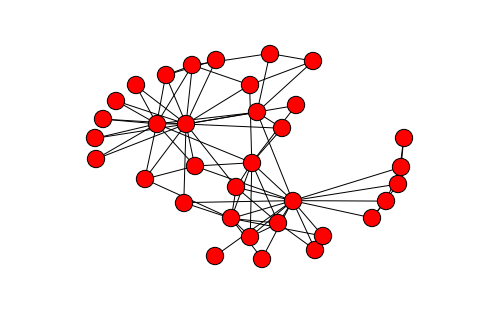

In [19]:
pos = nx.spring_layout(nx.karate_club_graph())
G = nx.karate_club_graph()
nx.draw(G, pos)

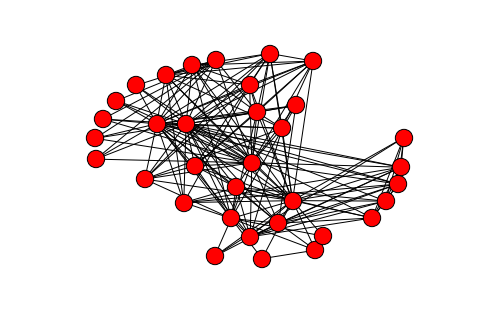

In [20]:
G2 = run_folds_alg(G)
nx.draw(G2, pos)

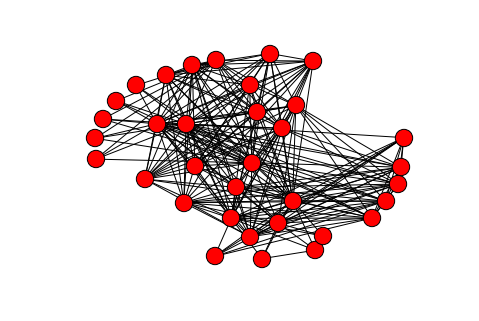

In [21]:
G3 = run_folds_alg(G2)
nx.draw(G3, pos)

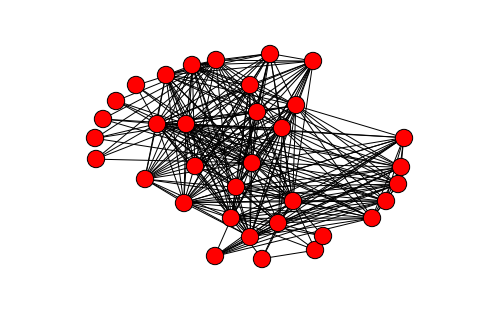

In [22]:
G4 = run_folds_alg(G3)
nx.draw(G4, pos)

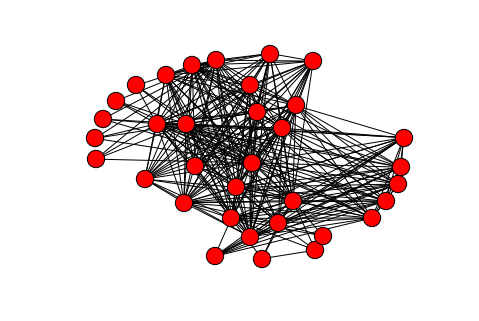

In [23]:
G5 = run_folds_alg(G4)
nx.draw(G5, pos)

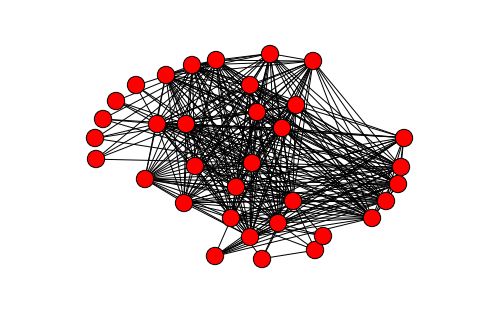

In [24]:
G6 = run_folds_alg(G5)
nx.draw(G6, pos)

In [54]:
time = [0]
n_edges = [nx.karate_club_graph().number_of_edges()]
ccoef = [nx.average_clustering(nx.karate_club_graph())]
graphs = [nx.karate_club_graph()]
nod_con = [nx.average_node_connectivity(nx.karate_club_graph())]
n = 1
for i in xrange(7):
    time.append(time[-1] + 1)
    graphs.append(run_folds_alg(graphs[-1]))
    ccoef.append(nx.average_clustering(graphs[-1]))
    nod_con.append(nx.average_node_connectivity(graphs[-1]))
    n_edges.append(graphs[-1].number_of_edges())

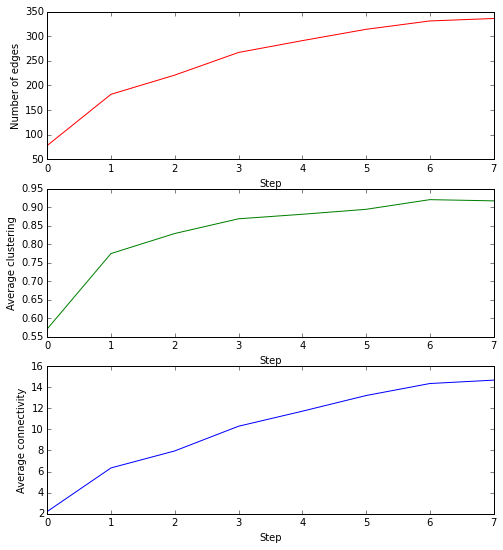

In [55]:
plt.figure(figsize = (8, 9))
plt.subplot(311)
plt.xlabel('Step')
plt.ylabel('Number of edges')
plt.plot(time, n_edges, 'r')
plt.subplot(312)
plt.xlabel('Step')
plt.ylabel('Average clustering')
plt.plot(time, ccoef, 'g')
plt.subplot(313)
plt.xlabel('Step')
plt.ylabel('Average connectivity')
plt.plot(time, nod_con, 'b')

In [56]:
n_edges

[78, 182, 221, 267, 291, 314, 331, 336]

561